In [81]:
import numpy as np
import math

rng1 = np.random.default_rng(seed=0)

def objective_function(x):
    """Keane's Bump function.
    n = dimension of the domain
    x = vector in the domain"""
    cos4 = 0
    cos2 = 1
    x_i = 0
    n = len(x)
    for i in range(n):
        cos4 += math.cos(x[i])**4
        cos2 *= math.cos(x[i])**2
        x_i += (i+1)*(x[i]**2)
    if x_i == 0:
        answer = None
    else:
        answer = np.abs((cos4 - 2*cos2)/math.sqrt(x_i))
    ## we are turning the maximization problem into a minimization problem
    return -1 * answer

def update_D(D, R):
    D =  0.9 * D + 0.21 * R
    min_step_size = 1e-3
    max_step_size = 1
    D = np.where(D < min_step_size, min_step_size, D)
    D = np.where(D > max_step_size, max_step_size, D)
    return D

def decrement_temperature(T, alpha):
    return T*alpha

def proposal(x, D, rng): ## Parks 1991
    while True:
        u = rng.uniform(-1, 1, size=len(x))
        x_new = x + np.dot(D, u)
        if np.all((x_new > 0) & (x_new < 10)):
            if np.sum(x_new) < 15 * len(x) / 2 and np.prod(x_new) > 0.75:
                break
    return x_new, u

def archive_function(x, archive, unchanged_counter):
    ## 10 best solutions 
    archive_limit = 10
    f = objective_function(x)
    if len(archive) < archive_limit:
        archive.append((x, f))
    else:
        archive.append((x, f))  # Update all elements
        archive.sort(key=lambda item: item[1])  # Sort the archive by objective function value
        archive = archive[:archive_limit]  # Keep only the top elements
    if np.array_equal(archive[0][0],x): ## if current solution is the best solution in archive, reset counter
        unchanged_counter = 0
    else:
        unchanged_counter += 1
    return archive, unchanged_counter

def find_Tin_White(Lk, n, rng): ## White 1984
    Tin = []
    for i in range(25):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        acceptanced_objectives = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            acceptanced_objectives.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(np.std(acceptanced_objectives))
    return np.average(Tin)

def find_Tin_kirkpatrick(Lk, n, rng): ## Kirkpatrick 1984
    Tin = []
    for i in range(50):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        accepted_deltas = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            if delta > 0:
                accepted_deltas.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(-1 * np.sum(accepted_deltas) / math.log(0.8))
    return np.average(Tin)

def main(x0, Lk, rng):
    x_prev = x0
    # T = find_Tin_White(Lk, len(x0), rng)
    T = find_Tin_kirkpatrick(Lk, len(x0), rng)
    print(f"Initial temperature: {T}")
    Din = np.identity(len(x0))
    D = Din
    accepted_solutions = []
    archive = []
    counter =  0
    max_iter = 10000
    alpha = 0.95
    unchanged_counter = 0
    unchanged_threshold = 3000
    while counter < max_iter and unchanged_counter < unchanged_threshold:
        acceptances_at_T = 0
        for i in range(Lk):
            x_new, u = proposal(x_prev, Din, rng)
            counter += 1
            R = np.abs(np.diag(np.dot(D, u)))
            delta = objective_function(x_new) - objective_function(x_prev)
            if delta < 0:
                x_prev = x_new
                acceptances_at_T += 1
                accepted_solutions.append(x_new)
                D = update_D(D, R)
                archive, unchanged_counter = archive_function(x_new, archive, unchanged_counter)
            else:
                step_size = np.sqrt(np.sum(R**2))
                p = np.exp(- (0.7 * delta) / (T * step_size))
                if rng.uniform() < p:
                    x_prev = x_new
                    acceptances_at_T += 1
                    accepted_solutions.append(x_new)
                    D = update_D(D, R)
                    archive, unchanged_counter = archive_function(x_new, archive, unchanged_counter)
                else:
                    unchanged_counter += 1
            if acceptances_at_T / Lk >= 0.6:
                break
        T = decrement_temperature(T, alpha)
        print(f"New temperature: {T}, acceptances at previous T: {acceptances_at_T/ Lk}, counter: {counter}")
    return accepted_solutions, archive
            


In [82]:
n = 2 ## 2D
while True:
    x = np.random.uniform(0, 10, size=n)
    if np.all((x > 0) & (x < 10)):
        if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
            break
accepted_solutions, archive = main(x, 150, rng1)


Initial temperature: 9.579321638100314
New temperature: 9.100355556195298, acceptances at previous T: 0.6, counter: 91
New temperature: 8.645337778385533, acceptances at previous T: 0.6, counter: 182
New temperature: 8.213070889466257, acceptances at previous T: 0.6, counter: 272
New temperature: 7.802417344992944, acceptances at previous T: 0.6, counter: 362
New temperature: 7.412296477743296, acceptances at previous T: 0.6, counter: 453
New temperature: 7.041681653856131, acceptances at previous T: 0.6, counter: 543
New temperature: 6.689597571163324, acceptances at previous T: 0.6, counter: 633
New temperature: 6.355117692605157, acceptances at previous T: 0.6, counter: 723
New temperature: 6.037361807974899, acceptances at previous T: 0.6, counter: 813
New temperature: 5.735493717576154, acceptances at previous T: 0.6, counter: 904
New temperature: 5.448719031697346, acceptances at previous T: 0.6, counter: 995
New temperature: 5.176283080112478, acceptances at previous T: 0.6, cou

In [83]:
print(archive)

[(array([1.433076  , 0.55003171]), -0.30734809885309244), (array([1.85548825, 0.43152329]), -0.28505222697076044), (array([1.75255266, 0.5116711 ]), -0.2791990474667212), (array([3.11678392, 1.54062947]), -0.2621614437717961), (array([3.12676928, 1.52895136]), -0.26201274608083797), (array([1.74131348, 0.54290214]), -0.2606562610192751), (array([3.09077403, 1.44616654]), -0.26017707786472644), (array([3.02176865, 1.55153007]), -0.2599882229095294), (array([3.1814877, 1.5427566]), -0.2579892235990608), (array([1.45043394, 0.60828414]), -0.25753959445788355)]


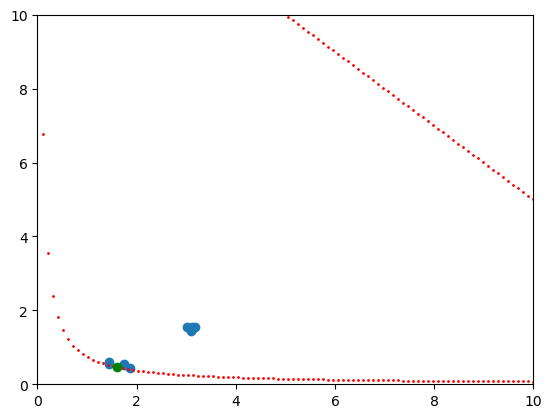

In [84]:
x1 = [t[0][0] for t in archive]
x2 = [t[0][1] for t in archive]
x = np.linspace(0.01, 10, 100)
y = 15 - x

y2 = 0.75 / x
global_minx = [1.60086044]
global_miny = [0.468498055]
import matplotlib.pyplot as plt
plt.scatter(x1, x2)
plt.scatter(x, y, c='red', s = 1)
plt.scatter(x, y2, c='red', s = 1)
plt.scatter(global_minx, global_miny, c='green')
plt.ylim(0, 10)
plt.xlim(0, 10)
plt.show()